In [9]:
from bs4 import BeautifulSoup
import requests
import multiprocessing as mp
import pandas as pd
import re
from nltk.stem import RSLPStemmer
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

def getPage(url):
    html = requests.get(url).content
    soup = BeautifulSoup(html, 'html.parser')
    links = soup.findAll('a')
    return list(dict.fromkeys([link.get('href') for link in links if link.get('title') != None and link.get('href') != None and str(link.get('title')).startswith('#Verificamos:')]))

def get_is_fake_and_text(url): 
    try:
        resp = requests.get(url)
        if(resp.status_code != 200):
            raise Exception('Error executing http call')

        html = resp.content
        soup = BeautifulSoup(html, 'html.parser')
        div_post_inner = soup.find('div', {'class': 'post-inner'})
        div_b_text = div_post_inner.findChildren('div', {'class': 'etiqueta etiqueta-7'})[0].text

        is_fake = True
        if div_b_text == 'VERDADEIRO':
            is_fake = True
        elif div_b_text == 'FALSO':  
            is_fake = False
        else:
            raise Exception('Not parseable')

        ps = div_post_inner.findAll('p', recursive=False)
        p_tag = ps[2].text
        return (is_fake, p_tag)
    except Exception as e:
        print('##### ERROR - ' + str(e))
        return (None, None)

In [ ]:
base_url = "https://piaui.folha.uol.com.br/lupa/page/"
pool = mp.Pool(mp.cpu_count())

v_links = []
pages = []
for i in range(1, 366):
    pages.append(base_url + str(i) + "/")

results = [pool.apply(getPage, args=((p,))) for p in pages]
pool.close()  
[v_links.extend(r) for r in results]
v_links = list(dict.fromkeys(v_links))

In [ ]:
df = pd.DataFrame(v_links)
df.to_csv('generated/piaui_verified_links.csv', index=False)

In [ ]:
pool = mp.Pool(mp.cpu_count())
results_get_fake = [pool.apply(get_is_fake_and_text, args=((p,))) for p in v_links]
pool.close()  

df = pd.DataFrame(results_get_fake)
df.to_csv('generated/results_get_fake.csv', index=False)

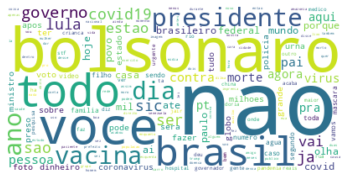

In [11]:
df = pd.read_csv('generated/results_get_fake.csv')
df['1'] = df['1'].astype(str)

remove_pontuacao = lambda x:  re.sub(r'[^\w\s]', '', x)
remove_nao_citacao = lambda x: x if x.startswith('“') else ''
remove_quebra_linha = lambda x:  re.sub(r'\\n', ' ', x)
remove_tabulacao = lambda x:  re.sub(r'\\t', ' ', x)
remove_multiplos_espacos = lambda x:  re.sub(' +', ' ', x)
get_between_markers = lambda x: '' if x.find('”') == -1 else x[x.find('“')+1: x.find('”')]
remove_little = lambda x: '' if len(x.split(' ')) < 10 else x

stemmer = RSLPStemmer()
stopws = stopwords.words('portuguese')

df['1'] = df['1'].map(remove_quebra_linha).map(remove_tabulacao).map(remove_multiplos_espacos).map(remove_nao_citacao).map(get_between_markers).map(remove_little).map(remove_pontuacao)

df.replace('FALSO', '', inplace=True)

df['1'] = df['1'].str.lower()

df['1'] = df['1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df['1'] = df['1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopws)]))

df['1'] = df['1'].str.strip()

df.replace('', None, inplace=True)

df.drop_duplicates(subset='1', keep='last', inplace=True)
df.dropna(inplace=True)
df['1'] = df['1'].str.lower()

df['1'] = df['1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

words = " ".join(df['1'])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

words = list(dict.fromkeys(" ".join(df['1']).split(" ")))


# df['1'] = df['1'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

# df.to_csv('generated/results_get_fake_built.csv', index=False)